# Prediction of origin for single electron event
This notebook aims to build a model able to predict where a single electron event originated.

In [1]:
"""
Here are the data files.  For all data files each image and label is on one row.  
The first 256 values in each row correspond to the 16x16 detector image and 
the last 6 values correspond to Energy1, Xpos1, Ypos1, Energy2, Xpos2, Ypos2.  
If there is no second particle then Energy2 = 0 and Xpos2 and Ypos2 are both -100.  
(When I run my model, I have to reset the -100 to 0).
 
CeBr10kSingle are 10,000 rows of data and labels for single interactions in the detector
CeBr10k_1.txt is 10,000 rows of data and labels with a mix of single interactions and double interactions
CeBr10.txt is a small file I use which contains 10 single interactions.
"""

import numpy as np
import matplotlib.pyplot as plt

# File import
PATH = "../data/small_sample/"
filenames = ["CeBr10kSingle_1.txt", "CeBr10kSingle_2.txt", "CeBr10k_1.txt", "CeBr10.txt"]

## single, mix, small define which dataset to load.
file_to_load = "single_1"

if file_to_load == "single_1":
    infile = PATH+filenames[0]
if file_to_load == "single_2":
    infile = PATH+filenames[1]
if file_to_load == "mix":
    infile = PATH+filenames[2]
if file_to_load == "small":
    infile = PATH+filenames[3]


data = np.loadtxt(infile)
n_pixels = data.shape[1] - 6 # the six params at the end are not part of the image
n_img = data.shape[0]
images = data[:, :n_pixels].reshape(n_img, 16, 16, 1)# reshape to image dims (batch, rows, cols, channels)
images = np.transpose(images, axes=[0, 2, 1, 3]) # transpose to correct spatial orientation
energy_pos = data[:, n_pixels:] # Energy1, Xpos1, Ypos1, Energy2, Xpos2, Ypos2

print("Image data shape: {}".format(images.shape))

if file_to_load in ["single_1", "single_2"]:
    energy = energy_pos[:,0]
    position = energy_pos[:,1:3]
    print("Energies shape: {}".format(energy.shape))
    print("Positions shape: {}".format(position.shape))
    

Image data shape: (10000, 16, 16, 1)
Energies shape: (10000,)
Positions shape: (10000, 2)



## Set up training and test data

In [2]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(images, position, test_size = 0.3)
print("Training and test data shapes:")
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))




Training and test data shapes:
x_train: (7000, 16, 16, 1)
x_test: (3000, 16, 16, 1)
y_train: (7000, 2)
y_test: (3000, 2)


## Build and compile model
Using Keras as our framework with Tensorflow backend

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend

# Parameters for the model
batch_size = 32
epochs = 10

# Set up sequetial model based on Keras CIFAR-10 example
model = Sequential()

# Add layers
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), padding='same'))
#model.add(Activation('relu'))
#model.add(Conv2D(64, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Dense(512))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('linear'))



# Custom definition of R2 score for metrics
def r2_keras(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + backend.epsilon()) )

# Compile model
model.compile(loss='mse',
              optimizer='adam',
              metrics=["mse", r2_keras])



Using TensorFlow backend.
W0718 15:27:12.350426 140179074164352 deprecation_wrapper.py:119] From /home/ulvik/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 15:27:12.361964 140179074164352 deprecation_wrapper.py:119] From /home/ulvik/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 15:27:12.364439 140179074164352 deprecation_wrapper.py:119] From /home/ulvik/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 15:27:12.398977 140179074164352 deprecation_wrapper.py:119] From /home/ulvik/.local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

## Train the model

In [4]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

W0718 15:27:12.502962 140179074164352 deprecation_wrapper.py:119] From /home/ulvik/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0718 15:27:12.570387 140179074164352 deprecation_wrapper.py:119] From /home/ulvik/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 7000 samples, validate on 3000 samples
Epoch 1/10
7000/7000 [==============================] - 2s 286us/step - loss: 88.4152 - mean_squared_error: 88.4152 - r2_keras: -4.1774 - val_loss: 18.6255 - val_mean_squared_error: 18.6255 - val_r2_keras: -0.0884
Epoch 2/10
7000/7000 [==============================] - 2s 256us/step - loss: 7.6252 - mean_squared_error: 7.6252 - r2_keras: 0.5592 - val_loss: 4.0530 - val_mean_squared_error: 4.0530 - val_r2_keras: 0.7522
Epoch 3/10
7000/7000 [==============================] - 2s 266us/step - loss: 2.1635 - mean_squared_error: 2.1635 - r2_keras: 0.8740 - val_loss: 2.0316 - val_mean_squared_error: 2.0316 - val_r2_keras: 0.8812
Epoch 4/10
7000/7000 [==============================] - 2s 253us/step - loss: 2.7649 - mean_squared_error: 2.7649 - r2_keras: 0.8334 - val_loss: 1.2960 - val_mean_squared_error: 1.2960 - val_r2_keras: 0.9246
Epoch 5/10
7000/7000 [==============================] - 2s 256us/step - loss: 1.0249 - mean_squared_error: 1.0249 

## Predict on test-set and plot some examples
To compare predicted positions with actual positions. 

In [5]:
predicted_pos = model.predict(x_test)

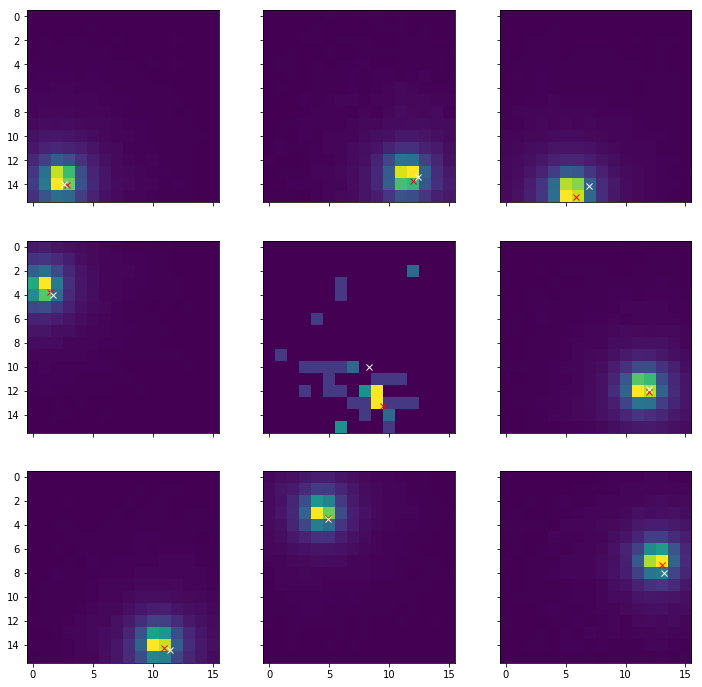

In [6]:


# Plot some images, with electron origin positions
%matplotlib inline

index = 100
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))

# Reshape test-data for plotting
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])
for i in range(3):
    for j in range(3):
        # plot image
        ax[i, j].imshow(x_test[index + i*3 + j])
        
        # plot true origin of event
        x = y_test[index + i*3 + j][0]
        y = y_test[index + i*3 + j][1]
        ax[i, j].plot(x, y, 'rx')
        
        # plot predicted origin of event
        x_pred = predicted_pos[index + i*3 + j][0]
        y_pred = predicted_pos[index + i*3 + j][1]
        ax[i, j].plot(x_pred, y_pred, 'wx')
plt.show()